In [1]:
# install uplift library scikit-uplift and other libraries
!pip install scikit-uplift dill catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.4 MB/s eta 0:00:00


# Load data



- `group` - treatment / control 
- `response_att` - binary target
- `CardHolder` - customer id
- `gender` - customer gender
- `age` - customer age

In [2]:
import numpy as np
import pandas as pd

path = "lenta.csv"
data = pd.read_csv(path)

In [5]:
data.head()

,CardHolder,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,...,sale_sum_6m_g24,sale_sum_6m_g25,sale_sum_6m_g26,sale_sum_6m_g32,sale_sum_6m_g33,sale_sum_6m_g44,sale_sum_6m_g54,stdev_days_between_visits_15d,stdev_discount_depth_15d,stdev_discount_depth_1m
0,16095858,47.0,3.0,22.0,19.0,3.0,28.0,8.0,7.0,6.0,...,3141.25,356.67,237.25,283.84,3648.23,1195.37,535.42,1.7078,0.2798,0.3008
1,15906620,57.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,...,113.39,62.69,58.71,87.01,179.83,0.00,122.98,0.0000,0.0000,0.0000
2,16495466,38.0,7.0,0.0,15.0,4.0,9.0,5.0,9.0,14.0,...,1239.19,533.46,83.37,593.13,1217.43,1336.83,3709.82,0.0000,NaN,0.0803
3,16570217,65.0,6.0,3.0,25.0,2.0,10.0,14.0,11.0,8.0,...,139.68,1849.91,360.40,175.73,496.73,172.58,1246.21,0.0000,0.0000,0.0000
4,16346871,61.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,3.0,...,226.98,168.05,461.37,0.00,237.93,225.51,995.27,1.4142,0.3495,0.3495


In [6]:
print(f"Dataset features shape: {data.shape}")


Dataset features shape: (687029, 196)


In [12]:
treatment = data['group']
target = data['response_att']
data_X=data.drop(['group','response_att'] , axis=1)


# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}

treatment = treatment.map(treat_dict)

In [13]:
# fill NaNs in the categorical feature `gender`
# for CatBoostClassifier
data_X['gender'] = data_X['gender'].fillna(value='Не определен')
print(data_X['gender'].value_counts(dropna=False))

gender
Ж               433448
М               243910
Не определен      9671
Name: count, dtype: int64


#####   train test split

In [14]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([treatment, target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    data_X,
    treatment,
    target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 194)
Validation shape: (206109, 194)


#  Class Transformation Approach (S-Learner)

In [15]:
from sklift.models import ClassTransformation
from catboost import CatBoostClassifier
from sklift.metrics import uplift_at_k
from sklift.metrics import uplift_by_percentile
from sklift.metrics import weighted_average_uplift
from sklift.viz import plot_uplift_by_percentile

estimator = CatBoostClassifier(verbose=100,
                               cat_features=['gender'],
                               random_state=42,
                               thread_count=1)
ct_model = ClassTransformation(estimator=estimator)

ct_model.fit(
    X=X_train,
    y=y_train,
    treatment=trmnt_train
)

# uplift predictions
uplift_ct = ct_model.predict(X_val)

In [19]:
# k = 10%
k = 0.1

# strategy='overall' sort by uplift treatment and control together
uplift_overall = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup = uplift_at_k(y_val, uplift_ct, trmnt_val, strategy='by_group', k=k)


print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")

uplift@10%: 0.1450 (sort groups by uplift together)
uplift@10%: 0.1520 (sort groups by uplift separately)


In [20]:
uplift_by_percentile(y_val, uplift_ct, trmnt_val,
                     strategy='overall',
                     total=True, std=True, bins=10)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,12632,7979,0.363046,0.218072,0.144974,0.004279,0.004623,0.006299
10-20,15531,5080,0.216792,0.188583,0.028210,0.003306,0.005488,0.006407
20-30,15799,4812,0.155896,0.141521,0.014375,0.002886,0.005025,0.005795
30-40,15654,4957,0.108087,0.099657,0.008430,0.002482,0.004255,0.004925
40-50,15780,4831,0.082193,0.079073,0.003120,0.002186,0.003882,0.004456
50-60,15741,4870,0.065117,0.057084,0.008032,0.001967,0.003325,0.003863
60-70,15739,4872,0.048605,0.045361,0.003244,0.001714,0.002981,0.003439
70-80,15853,4758,0.039992,0.040143,-0.000150,0.001556,0.002846,0.003243
80-90,15926,4685,0.035728,0.029242,0.006485,0.001471,0.002462,0.002867


In [21]:
uplift_full_data = weighted_average_uplift(y_val, uplift_ct, trmnt_val, bins=10)
print(f"average uplift on full data: {uplift_full_data:.4f}")

average uplift on full data: 0.0190


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


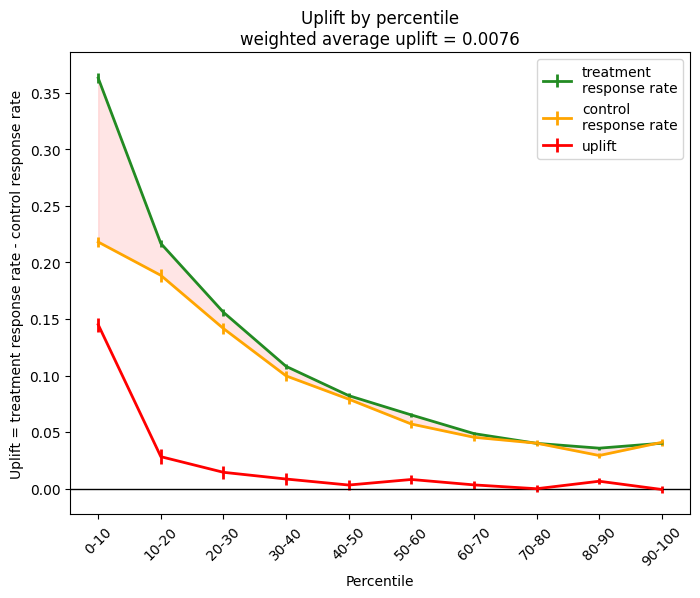

In [22]:
## uplift_by_percentile  plot
# line plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='line');

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


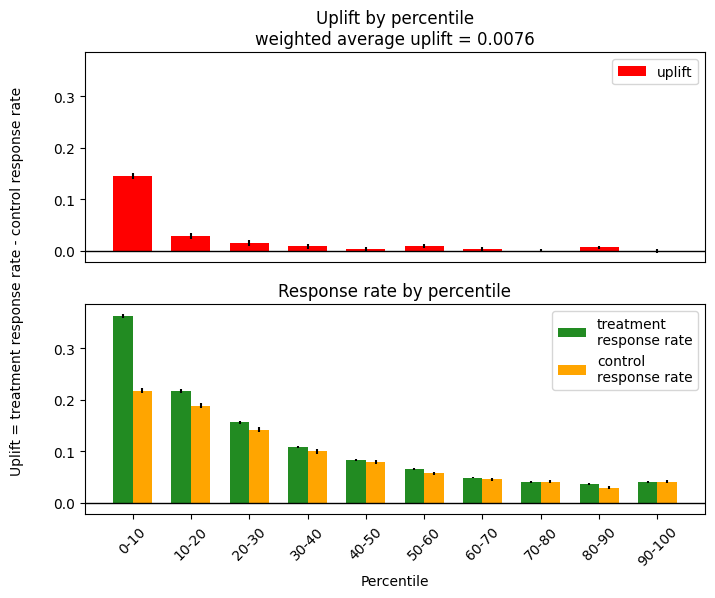

In [23]:
# bar plot
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

#   Qini curve

The curve plots the absolute incremental outcome of the treated group compared to group with no treatment.


plot Qini curve:
- `blue line` is a `real Qini curve` based on data.
- `red line` is an `ideal Qini curve` based on data. Code: `perfect=True`
- `grey line` is a `random Qini curve` based on data
    

##  `AUQC` (`area under Qini curve` or `Qini coefficient`)

`Qini coefficient` = `light blue area between the real Qini curve and the random Qini curve normalized on area between the random and the ideal line`



- metric is printed at the title of the Qini curve plot
- can be called as a separate function

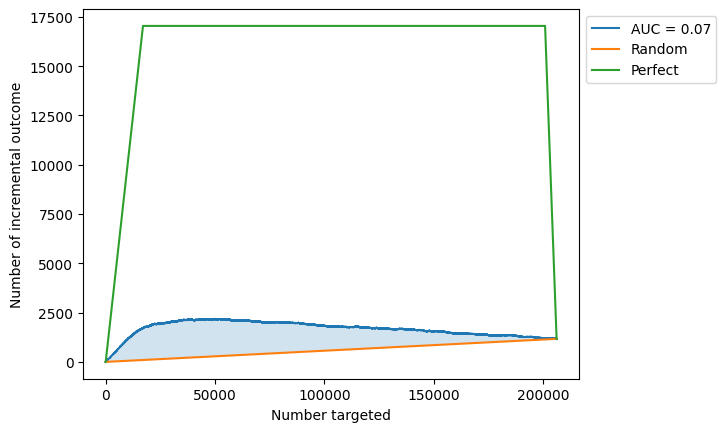

In [24]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=True);

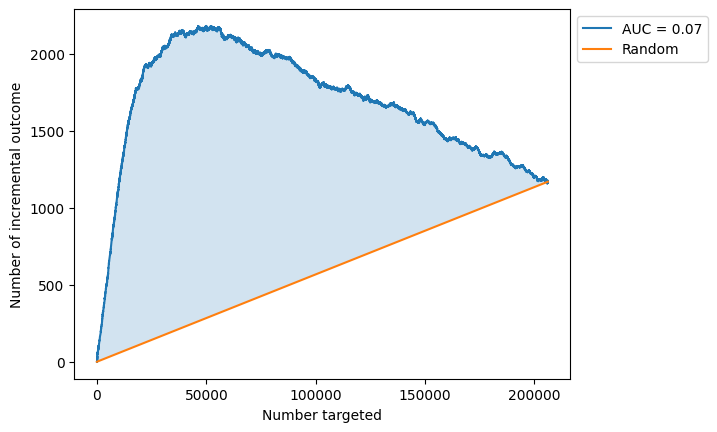

In [25]:
# no ideal Qini curve
# only real Qini curve
# perfect=False
plot_qini_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [26]:
from sklift.metrics import qini_auc_score

# AUQC = area under Qini curve = Qini coefficient
auqc = qini_auc_score(y_val, uplift_ct, trmnt_val)
print(f"Qini coefficient on full data: {auqc:.4f}")

Qini coefficient on full data: 0.0702


##  `Uplift curve`

The Uplift curve plots incremental uplift.


   - `blue line` is a `real Uplift curve` based on data.
   - `red line` is an `ideal Uplift curve` based on data. Code: `perfect=True`
   - `grey line` is a `random Uplift curve` based on data.
    

##  `AUUQ` (`area under uplift curve`)

- `Area under uplift curve` = blue area between the real Uplift curve and the random Uplift curve
    - appears at the title of the Uplift curve plot
    - can be called as a separate function


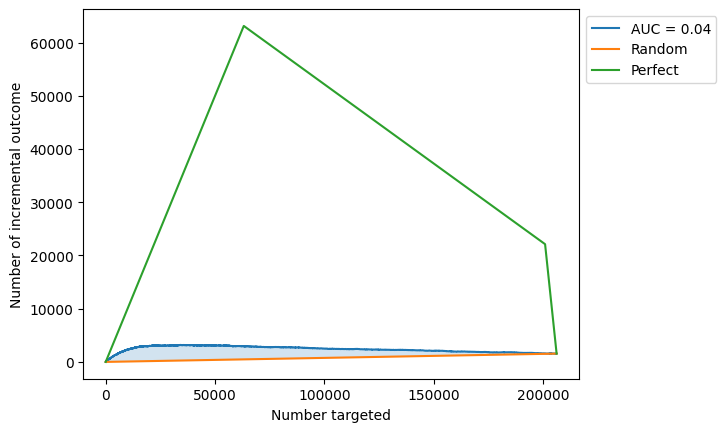

In [27]:
from sklift.viz import plot_uplift_curve

# with ideal curve
# perfect=True
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=True);

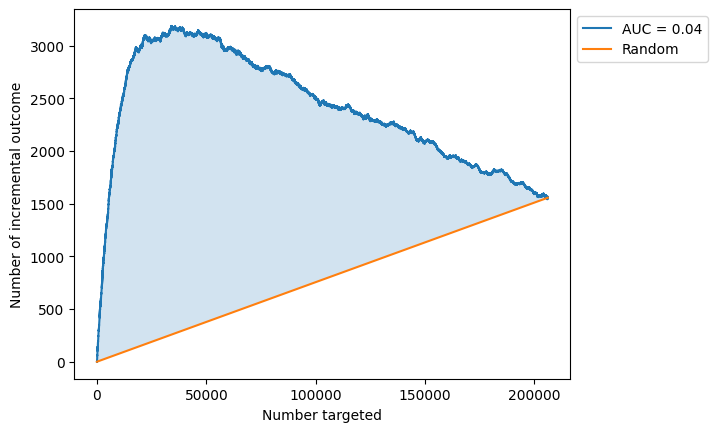

In [28]:
# only real
# perfect=False
plot_uplift_curve(y_val, uplift_ct, trmnt_val, perfect=False);

In [29]:
from sklift.metrics import uplift_auc_score

# AUUQ = area under uplift curve
auuc = uplift_auc_score(y_val, uplift_ct, trmnt_val)
print(f"Uplift auc score on full data: {auuc:.4f}")

Uplift auc score on full data: 0.0427


In [ ]:
########################################################################################################################################
########################################################################################################################################
#####################  Previosuly we have used catboost only . Now lets use other models as see their effectiveness as well   ##########
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################

In [ ]:
from sklearn.impute import SimpleImputer

data_X_g = data_X.copy()
data_X_g['gender'] = data_X_g['gender'].map(mapping)
data_X_filled = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(data_X_g)


X_train_f, X_val_f, trmnt_train_f, trmnt_val_f, y_train_f, y_val_f = train_test_split(
    data_X_filled,
    treatment,
    target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

### Train models

In [37]:
from sklift.models import ClassTransformation
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

estimator_rf = RandomForestClassifier(max_depth=10, random_state=42)
estimator_hgb = HistGradientBoostingClassifier(learning_rate=0.01, random_state=42)

ct_rf_model = ClassTransformation(estimator=estimator_rf)
ct_hgb_model = ClassTransformation(estimator=estimator_hgb)

In [38]:
ct_rf_model.fit(
    X=X_train_f,
    y=y_train_f,
    treatment=trmnt_train_f
)

ClassTransformation(estimator=RandomForestClassifier(max_depth=10,
                                                     random_state=42))

In [39]:
ct_hgb_model.fit(
    X=X_train,
    y=y_train,
    treatment=trmnt_train
)

ClassTransformation(estimator=HistGradientBoostingClassifier(learning_rate=0.01,
                                                             random_state=42))

### Predict

In [42]:
uplift_ct_rf = ct_rf_model.predict(X_val_f)

In [43]:
uplift_ct_hgb = ct_hgb_model.predict(X_val)

### Metrics

In [44]:
k = 0.1

# strategy='overall' sort by uplift treatment and control together
uplift_overall_rf = uplift_at_k(y_val_f, uplift_ct_rf, trmnt_val_f, strategy='overall', k=k)
uplift_overall_hgb = uplift_at_k(y_val, uplift_ct_hgb, trmnt_val, strategy='overall', k=k)

# strategy='by_group' sort by uplift treatment and control separately
uplift_bygroup_rf = uplift_at_k(y_val_f, uplift_ct_rf, trmnt_val_f, strategy='by_group', k=k)
uplift_bygroup_hgb = uplift_at_k(y_val, uplift_ct_hgb, trmnt_val, strategy='by_group', k=k)

print('--------CatBoost------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")
print('\n')
print('--------RandomForest------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall_rf:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup_rf:.4f} (sort groups by uplift separately)")
print('\n')
print('--------GradientBoosting------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall_hgb:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup_hgb:.4f} (sort groups by uplift separately)")

--------CatBoost------------
uplift@10%: 0.1450 (sort groups by uplift together)
uplift@10%: 0.1520 (sort groups by uplift separately)


--------RandomForest------------
uplift@10%: 0.0414 (sort groups by uplift together)
uplift@10%: 0.0274 (sort groups by uplift separately)


--------GradientBoosting------------
uplift@10%: 0.1531 (sort groups by uplift together)
uplift@10%: 0.1859 (sort groups by uplift separately)


#### weighted average uplift

In [45]:
uplift_full_data_rf = weighted_average_uplift(y_val_f, uplift_ct_rf, trmnt_val_f, bins=10)
uplift_full_data_hgb = weighted_average_uplift(y_val, uplift_ct_hgb, trmnt_val, bins=10)

print(f"average uplift on full data (CatBoost): {uplift_full_data:.4f}")
print(f"average uplift on full data (RandomForest): {uplift_full_data_rf:.4f}")
print(f"average uplift on full data (GradientBoosting): {uplift_full_data_hgb:.4f}")

average uplift on full data (CatBoost): 0.0190
average uplift on full data (RandomForest): 0.0149
average uplift on full data (GradientBoosting): 0.0198


#### uplift_by_percentile plot

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


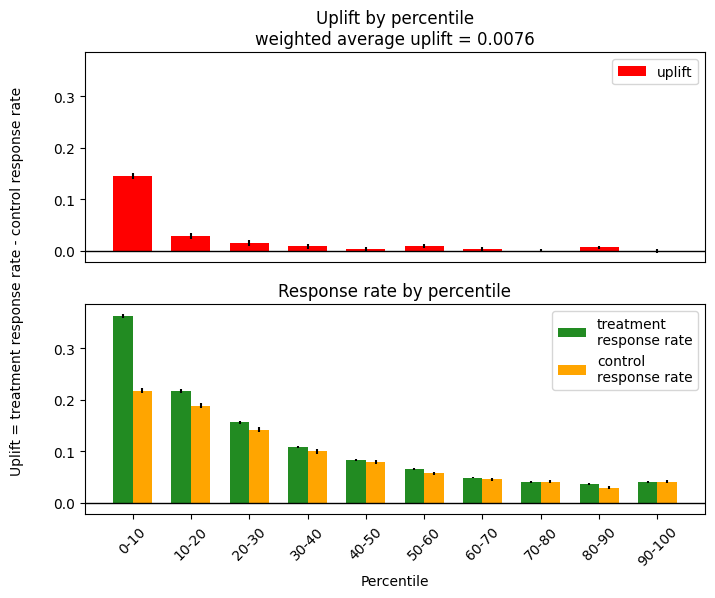

In [46]:
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


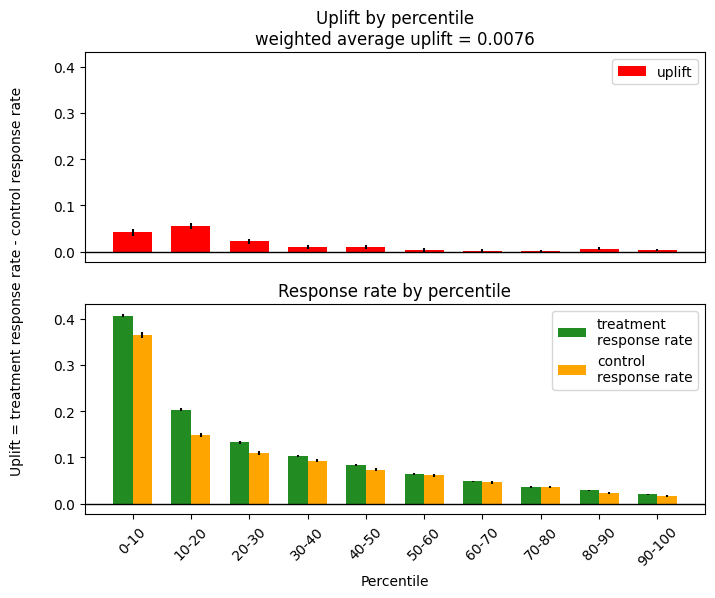

In [47]:
plot_uplift_by_percentile(y_val_f, uplift_ct_rf, trmnt_val_f, strategy='overall', kind='bar');

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


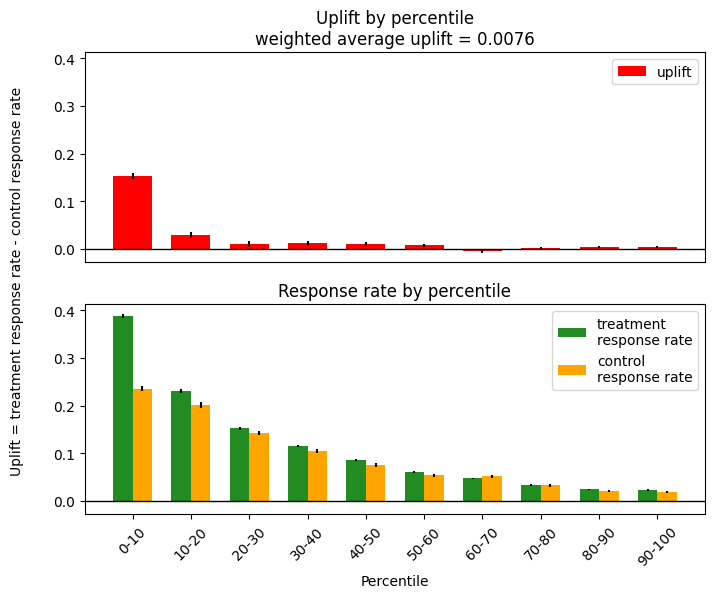

In [48]:
plot_uplift_by_percentile(y_val, uplift_ct_hgb, trmnt_val, strategy='overall', kind='bar');

####  Uplift curve

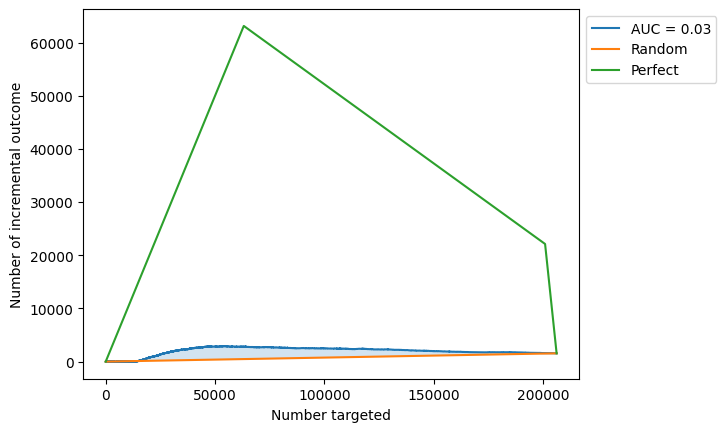

In [49]:
plot_uplift_curve(y_val_f, uplift_ct_rf, trmnt_val_f, perfect=True);

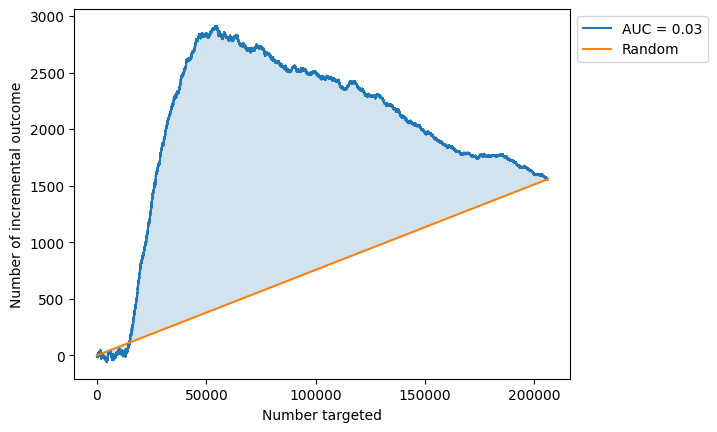

In [50]:
plot_uplift_curve(y_val_f, uplift_ct_rf, trmnt_val_f, perfect=False);

In [51]:
auuc_rf = uplift_auc_score(y_val_f, uplift_ct_rf, trmnt_val_f)

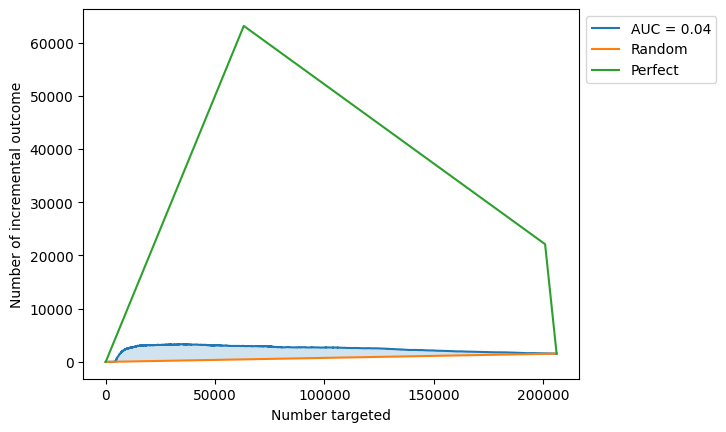

In [52]:
plot_uplift_curve(y_val, uplift_ct_hgb, trmnt_val, perfect=True);

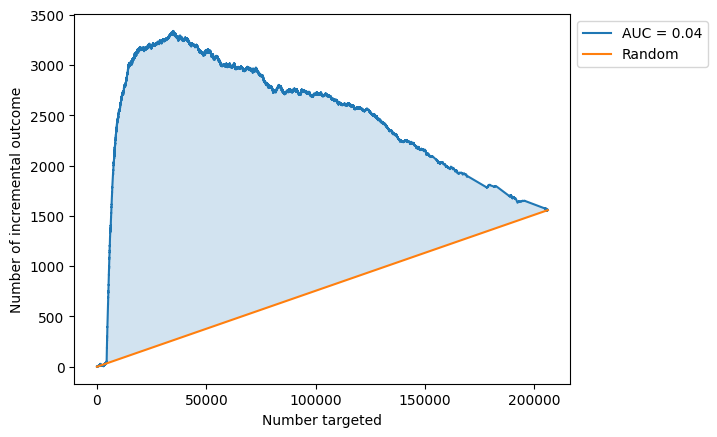

In [53]:
plot_uplift_curve(y_val, uplift_ct_hgb, trmnt_val, perfect=False);

In [54]:
auuc_hgb = uplift_auc_score(y_val, uplift_ct_hgb, trmnt_val)

In [55]:
print(f"Uplift auc score on full data (RandomForest): {auuc_rf:.4f}")
print(f"Uplift auc score on full data (GradientBoosting): {auuc_hgb:.4f}")

Uplift auc score on full data (RandomForest): 0.0323
Uplift auc score on full data (GradientBoosting): 0.0443


#  TwoModels Approach (T- Learner)

In [57]:
from sklift.models import TwoModels

estimator_trmnt = CatBoostClassifier(silent=True, thread_count=2, random_state=42)
estimator_ctrl = CatBoostClassifier(silent=True, thread_count=2, random_state=42)

# define approach
tm_ctrl = TwoModels(
    estimator_trmnt=estimator_trmnt,
    estimator_ctrl=estimator_ctrl,
    method='ddr_control'
)

# fit the models
tm_ctrl = tm_ctrl.fit(
    X_train, y_train, trmnt_train,
    estimator_trmnt_fit_params={'cat_features': ['gender']},
    estimator_ctrl_fit_params={'cat_features': ['gender']}
)
uplift_tm_ctrl = tm_ctrl.predict(X_val)

### Metrics

#### Uplift@k

In [58]:
uplift_overall_sm = uplift_at_k(y_val, uplift_sm, trmnt_val, strategy='overall', k=k)
uplift_bygroup_sm = uplift_at_k(y_val, uplift_sm, trmnt_val, strategy='by_group', k=k)

uplift_overall_tm = uplift_at_k(y_val, uplift_tm_ctrl, trmnt_val, strategy='overall', k=k)
uplift_bygroup_tm = uplift_at_k(y_val, uplift_tm_ctrl, trmnt_val, strategy='by_group', k=k)

print('--------CatBoost (ClassTransformation)------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup:.4f} (sort groups by uplift separately)")
print('\n')
print('--------CatBoost (SoloModel)------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall_sm:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup_sm:.4f} (sort groups by uplift separately)")
print('\n')
print('--------CatBoost (TwoModels)------------')
print(f"uplift@{k * 100:.0f}%: {uplift_overall_tm:.4f} (sort groups by uplift together)")
print(f"uplift@{k * 100:.0f}%: {uplift_bygroup_tm:.4f} (sort groups by uplift separately)")

--------CatBoost (ClassTransformation)------------
uplift@10%: 0.1450 (sort groups by uplift together)
uplift@10%: 0.1520 (sort groups by uplift separately)


--------CatBoost (SoloModel)------------
uplift@10%: 0.0108 (sort groups by uplift together)
uplift@10%: 0.0110 (sort groups by uplift separately)


--------CatBoost (TwoModels)------------
uplift@10%: 0.0127 (sort groups by uplift together)
uplift@10%: 0.0134 (sort groups by uplift separately)


#### weighted average uplift

In [59]:
uplift_full_data_sm = weighted_average_uplift(y_val, uplift_sm, trmnt_val, bins=10)
uplift_full_data_tm = weighted_average_uplift(y_val, uplift_tm_ctrl, trmnt_val, bins=10)

print(f"average uplift on full data (ClassTransformstionCB): {uplift_full_data:.4f}")
print(f"average uplift on full data (SoloModelCB): {uplift_full_data_sm:.4f}")
print(f"average uplift on full data (TwoModelsCB): {uplift_full_data_tm:.4f}")

average uplift on full data (ClassTransformstionCB): 0.0190
average uplift on full data (SoloModelCB): 0.0068
average uplift on full data (TwoModelsCB): 0.0063


#### uplift_by_percentile plot

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


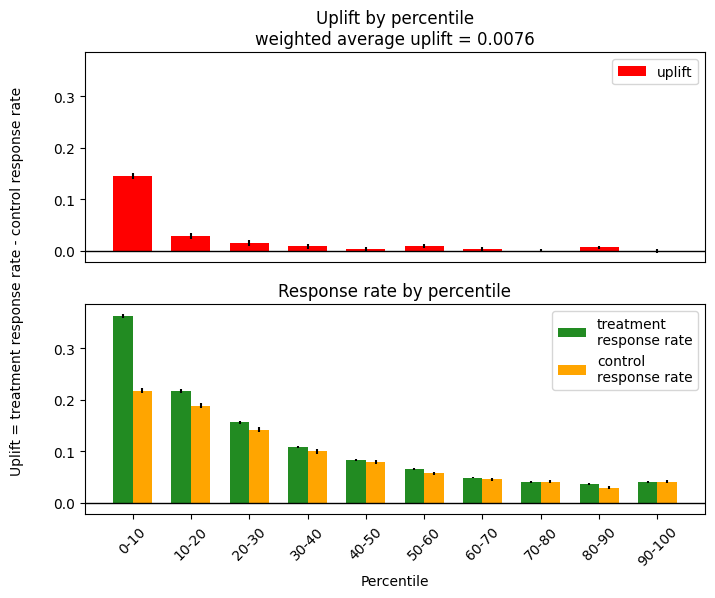

In [60]:
plot_uplift_by_percentile(y_val, uplift_ct, trmnt_val, strategy='overall', kind='bar');

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


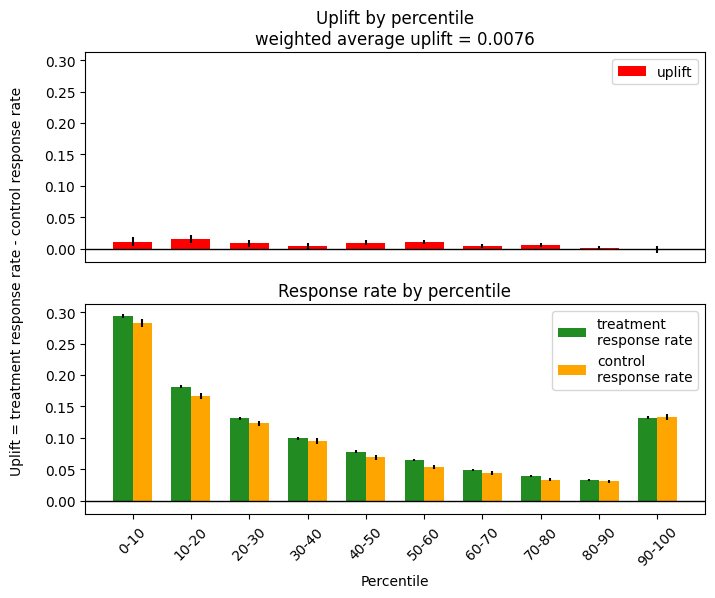

In [61]:
plot_uplift_by_percentile(y_val, uplift_sm, trmnt_val, strategy='overall', kind='bar');

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


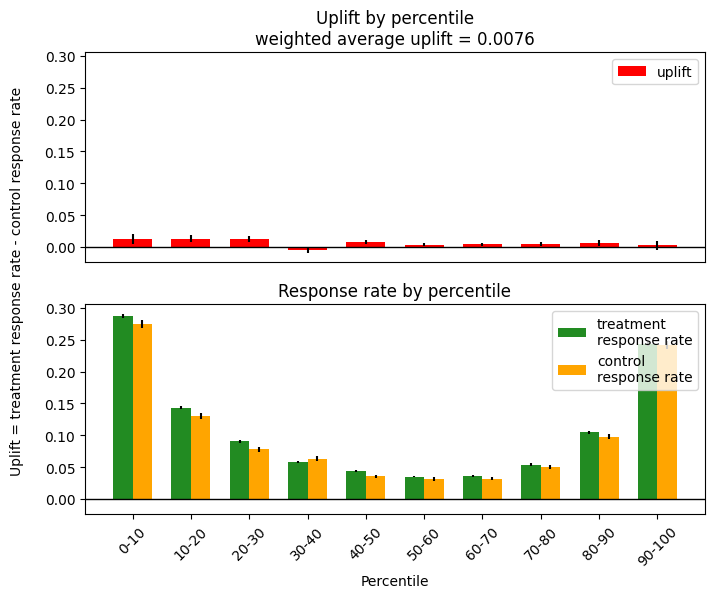

In [62]:
plot_uplift_by_percentile(y_val, uplift_tm_ctrl, trmnt_val, strategy='overall', kind='bar');

####  Uplift curve

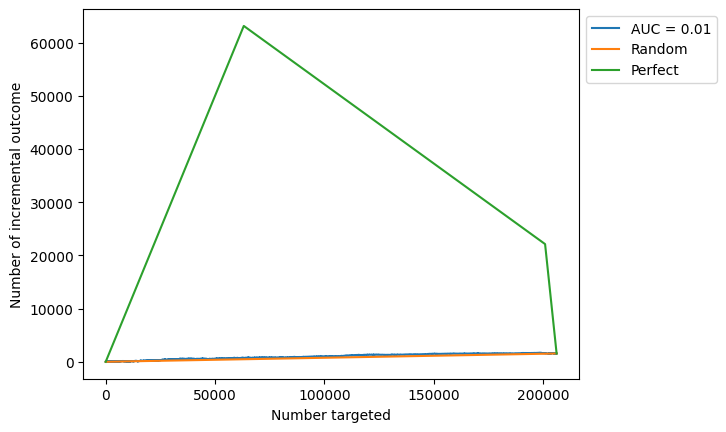

In [63]:
plot_uplift_curve(y_val, uplift_sm, trmnt_val, perfect=True);

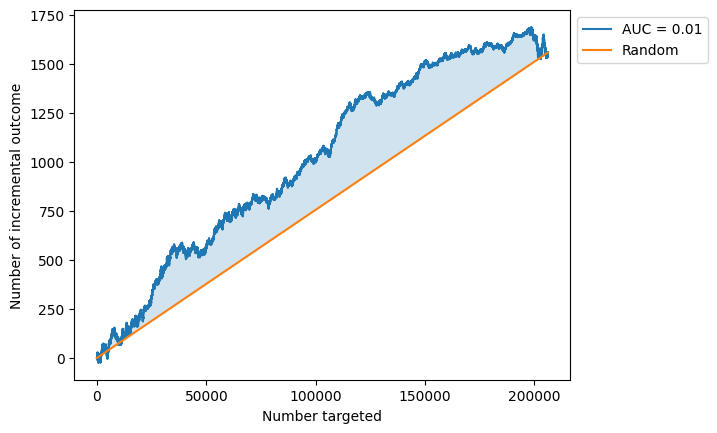

In [64]:
plot_uplift_curve(y_val, uplift_sm, trmnt_val, perfect=False);

In [65]:
auuc_sm = uplift_auc_score(y_val, uplift_sm, trmnt_val)

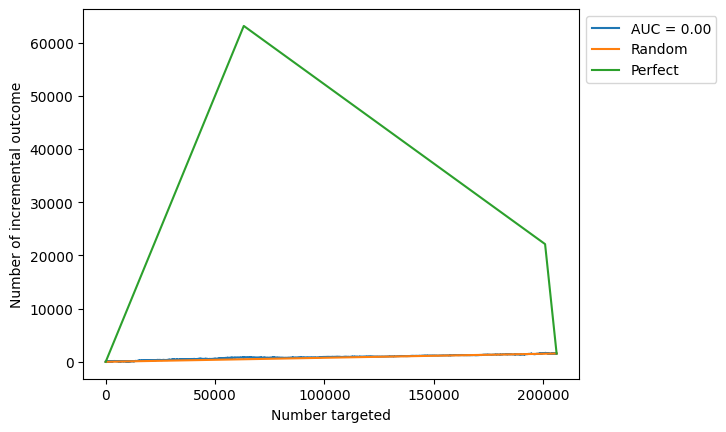

In [66]:
plot_uplift_curve(y_val, uplift_tm_ctrl, trmnt_val, perfect=True);

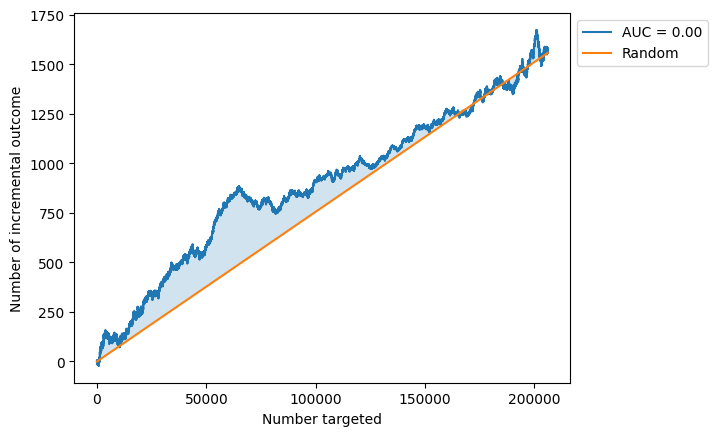

In [67]:
plot_uplift_curve(y_val, uplift_tm_ctrl, trmnt_val, perfect=False);

In [68]:
auuc_tm = uplift_auc_score(y_val, uplift_tm_ctrl, trmnt_val)

In [69]:
print(f"Uplift auc score on full data (ClassTransformstionCB): {auuc:.4f}")
print(f"Uplift auc score on full data (SoloModelCB): {auuc_sm:.4f}")
print(f"Uplift auc score on full data (TwoModelsCB): {auuc_tm:.4f}")

Uplift auc score on full data (ClassTransformstionCB): 0.0427
Uplift auc score on full data (SoloModelCB): 0.0063
Uplift auc score on full data (TwoModelsCB): 0.0030
